# Quick starry.grad tutorial

In this tutorial, we'll go over how to use the derivatives computed by `starry` to help in optimization/inference problems. Since the equations in `starry` are all analytic, the code uses [autodifferentiation](https://en.wikipedia.org/wiki/Automatic_differentiation) to analytically (and quickly) compute gradients of the model with respect to all input parameters.

Let's begin by importing some stuff.

In [2]:
import starry
import numpy as np
import matplotlib.pyplot as pl
from tqdm import tqdm
from scipy.optimize import minimize
import sys
np.random.seed(8765)

In [2]:
%matplotlib inline

For convenience, before we get started, let's write a quick function to show side-by-side images of the map as it rotates about its axis. This will help us visualize our original map and the inferred one:

In [3]:
def show(map, res=100, nframes=8):
    x, y = np.meshgrid(np.linspace(-1, 1, res), np.linspace(-1, 1, res))
    theta = np.linspace(0, 360, nframes, endpoint=False)
    fig, ax = pl.subplots(1, nframes, figsize=(2 * nframes, 2))
    for n in range(nframes):
        I = [map.evaluate(theta=theta[n], x=x[j], y=y[j]) for j in range(res)]
        ax[n].imshow(I, origin="lower", interpolation="none", cmap='plasma', extent=(-1, 1, -1, 1))
        ax[n].axis('off')

## Generating a map

Let's create a low degree ($l_{max} = 5$) map of the Earth and plot it using our `show()` function:

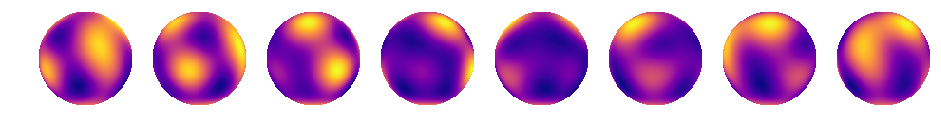

In [4]:
lmax = 5
earth = starry.Map(lmax)
earth.load_image('earth')
show(earth)

Not terrible! Africa and Europe are kind of one big blob, but you can pick out the Americas, Asia, and a smudge that looks to be Australia. Let's try to recover this map from some occultation light curves!

## Generating synthetic occultation data

We're going to pretend that there's an occultor of radius $r_o = 0.1$ tracing random paths across the surface of our planet as it rotates. Say we observe 20 of these occultations, each with ~100 cadences. Say we also have a ridiculously good telescope and our SNR is huge, so I'm not going to bother noising the data (though you're encouraged to play around with this!) 

Let's generate some fake data.

In [5]:
npts = 100
nevents = 20
ro = 0.1
xo = []
yo = []
theta = []
dy = []
n = 0
while n < nevents:
    # Randomize the occultor path. We randomly pick
    # a minimum impact parameter `ymin`, the angle of
    # the transit chord `alpha`, and the rotational
    # phase of the planet `theta`:
    ymin = 2 * np.random.random() - 1
    alpha = np.pi * np.random.random() - np.pi / 2
    x = np.linspace(-1.5, 1.5, npts)
    y = ymin + x * np.tan(alpha)
    inds = x ** 2 + y ** 2 <= 1.5 ** 2
    if len(x[inds]) > 10:
        xo.append(x[inds])
        yo.append(y[inds])
        dy.append(ro / np.cos(alpha))
        theta.append(np.ones_like(x[inds]) * np.random.random() * 360)
        n += 1

Now that we have our occultation parameters, let's compute the light curves for each event using `starry` and plot them:

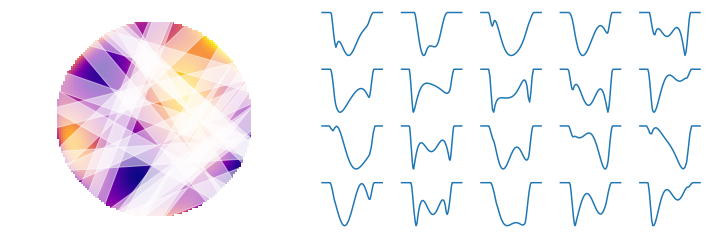

In [6]:
# Plot the rays the occultor traces
fig = pl.figure(figsize=(14, 4))
ax = pl.subplot2grid((3, 10), (0, 0), rowspan=3, colspan=4)
res = 100
x, y = np.meshgrid(np.linspace(-1, 1, res), np.linspace(-1, 1, res))
I = [earth.evaluate(x=x[j], y=y[j]) for j in range(res)]
ax.imshow(I, origin="lower", interpolation="none", cmap='plasma', extent=(-1, 1, -1, 1))
for i in range(nevents):
    ax.fill_between(xo[i], yo[i] - dy[i], yo[i] + dy[i], color='w', alpha=0.5)
ax.set_aspect(1)
ax.set_xlim(-1 - ro, 1 + ro);
ax.set_ylim(-1 - ro, 1 + ro);
ax.axis('off');

# Plot the light curves
axlc = np.array([[pl.subplot2grid((4, 10), (i, j)) for i in range(4)] for j in range(4, 9)]).flatten()
flux = [None for i in range(nevents)]
for i in range(nevents):
    flux[i] = earth.flux(xo=xo[i], yo=yo[i], ro=ro, theta=theta[i])
    axlc[i].plot(flux[i])
    axlc[i].axis('off')

Those look pretty cool -- the information content of these light curves is huge! To make the inference problem easier, let's concatenate all the events into a single dataset:

In [7]:
xo = np.concatenate(xo)
yo = np.concatenate(yo)
theta = np.concatenate(theta)
flux = np.concatenate(flux)

## Exocartography!

Now we're ready to be exocartographers. Armed with our dataset (the `xo`, `yo`, `theta`, and `flux` arrays), our task is to find the $(l_{max} + 1)^2 = 36$ map coefficients that best explain the features in the light curves. We'll do this by minimizing an objective function, which in this case is just plain old chi-squared: the sum of the squares of the difference between our model and the data, normalized by the standard errors. Since our errors are formally zero (since we didn't add any noise), let's set $\sigma$ to something small but nonzero so we don't run into numerical issues.

Here's our chi-squared function:

In [8]:
def chisq(y, map, xo, yo, ro, theta, flux, sigma=0.001):
    # Assign the map coefficients
    n = 0
    for l in range(1, map.lmax + 1):
        for m in range(-l, l + 1):
            map[l, m] = y[n]
            n += 1
            
    # Compute the model and the chi-squared
    model = map.flux(xo=xo, yo=yo, ro=ro, theta=theta)
    chi2 = np.sum((model - flux) ** 2) / sigma ** 2

    # Return chi squared
    return chi2

(Note that we're actually fixing the $Y_{0,0}$ coefficient at unity, so we're really solving for 35 coefficients.)

Let's use `scipy.minimize` to minimize the chi-squared. We initialize the solver with random map coefficients (and fix the zeroth coefficient to one).

In [9]:
y = 0.1 * np.random.randn((lmax + 1) ** 2)
map = starry.Map(lmax)
map[0, 0] = 1
%time res = minimize(chisq, y[1:], args=(map, xo, yo, ro, theta, flux))
print(res.message)
print("Function calls: %d" % res.nfev)
print("Best chi-squared: %.5e" % res.fun)
n = 0
for l in range(1, map.lmax + 1):
    for m in range(-l, l + 1):
        map[l, m] = res.x[n]
        n += 1

CPU times: user 43.9 s, sys: 677 ms, total: 44.6 s
Wall time: 24.3 s
Desired error not necessarily achieved due to precision loss.
Function calls: 5710
Best chi-squared: 1.68975e-06


Looks like it worked! When I ran this on my MacBook, it took **44 seconds** and **5710 function calls**. Here's what our recovered map looks like:

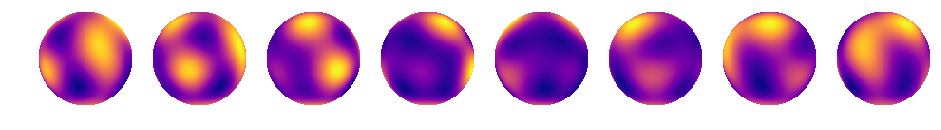

In [10]:
show(map)

For comparison, here's the original map:

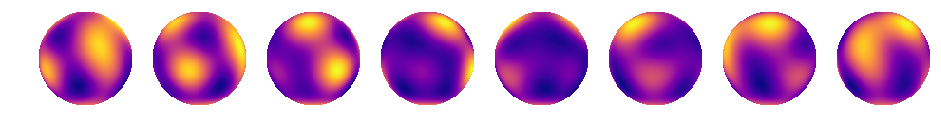

In [11]:
show(earth)

They're practically identical! Note how tiny the chi-squared is: we definitely found the global minimum. (Remember, though, this is pretty unrealistic since there's no noise!)

## Exo-autodiff-cartography

If you've been paying close attention, you'll notice I didn't actually pass any gradient information to `scipy.minimize`, so a lot of time was spent by the optimizier trying to figure out which direction (in a 35-dimensional space) to take steps in. This is pretty inefficient, especially since our formulae are analytic and we can easily compute gradients! So let's define a new chi-squared function that returns the gradient of the chi-squared in addition to its value:

In [12]:
def chisq_grad(y, map, xo, yo, ro, theta, flux, sigma=0.001):
    # Assign the map coefficients
    n = 0
    for l in range(1, map.lmax + 1):
        for m in range(-l, l + 1):
            map[l, m] = y[n]
            n += 1
            
    # Compute the model and the chi-squared
    model = map.flux(xo=xo, yo=yo, ro=ro, theta=theta)
    chi2 = np.sum((model - flux) ** 2) / sigma ** 2
    
    # Get the derivatives of the model w/ respect to y
    dmdy = [map.gradient['Y_{%d,%d}' % (l, m)] for l in range(1, map.lmax + 1) for m in range(-l, l + 1)]
    
    # Now compute the gradient of chi-squared with respect to y
    grad = np.sum(2 * (model - flux) * dmdy, axis=1) / sigma ** 2
        
    # Return chi squared **and** gradient
    return chi2, grad

Note that whenever `map.flux()` is called, derivatives of the flux are stored in `map.gradient`, which is a dictionary. The derivative of chi-squared with respect to the map coefficients is, from simple calculus:

$\frac{\mathrm{d}\ \chi^2}{\mathrm{d}\ \mathbf{y}} = \frac{\mathrm{d}}{\mathrm{d}\ \mathbf{y}} \left( \sum \frac{(m - f)^2}{\sigma^2} \right) = \frac{2}{\sigma^2} \sum (m - f) \frac{\mathrm{d}\ m}{\mathrm{d}\ \mathbf{y}}$

where $m$ is the model, $\mathbf{y}$ are the coefficients, $f$ is the flux (our data), and $\sigma$ are the standard errors.

As before, let's call the minimizer, but this time we specify `jac=True` to let `scipy` know that our objective function returns the Jacobian (a derivative vector) in addition to the chi-squared.

Note that we now have to use `starry.grad.Map` (instead of `starry.Map`) to get `starry` to compute gradients:

In [13]:
y = 0.1 * np.random.randn((lmax + 1) ** 2)
map = starry.grad.Map(lmax)
map[0, 0] = 1
%time res = minimize(chisq_grad, y[1:], args=(map, xo, yo, ro, theta, flux), jac=True)
print(res.message)
print("Function calls: %d" % res.nfev)
print("Best chi-squared: %.5e" % res.fun)
n = 0
for l in range(1, map.lmax + 1):
    for m in range(-l, l + 1):
        map[l, m] = res.x[n]
        n += 1

CPU times: user 9.76 s, sys: 224 ms, total: 9.98 s
Wall time: 2.67 s
Optimization terminated successfully.
Function calls: 60
Best chi-squared: 5.57097e-17


Woot! When I ran this on my laptop, it took **9 seconds** and **60 function calls**. That's more than **six times faster** than the previous approach, required 73 times fewer function evaluations, and **just look at that chi-squared!**

Here's our recovered map:

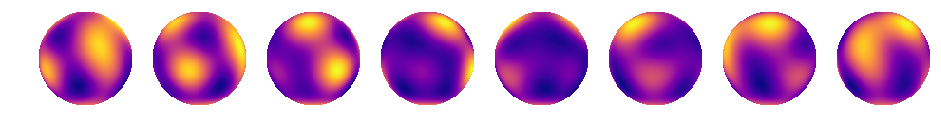

In [14]:
show(map)

And the original map for comparison:

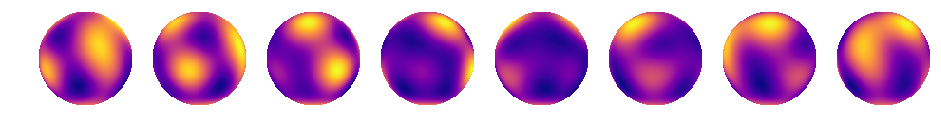

In [15]:
show(earth)

That's all for now!